In [14]:
# =========================
# Step 0: Imports & Seed
# =========================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

np.random.seed(42)  # reproducible results


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# =========================================
# Step 1: 4x4 Maze, Start, and Goal
# 0 = free cell, 1 = wall
# =========================================
maze = np.array([
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [1, 0, 1, 0],
    [1, 0, 0, 0]
], dtype=int)

start = (0, 0)   # Top-left corner
goal  = (0, 3)   # top-right corner

rows, cols = maze.shape

# # Quick preview
# cmap_preview = ListedColormap(["white", "black"])
# plt.figure(figsize=(4,4))
# plt.imshow(maze, cmap=cmap_preview)

# # Mark Start (circle) and Goal (star)
# plt.scatter([start[1]], [start[0]], s=150, marker='o', edgecolor='k', label='Start', color='green')
# plt.scatter([goal[1]], [goal[0]], s=200, marker='*', edgecolor='k', label='Goal', color='red')

# plt.title("4x4 Maze Preview (0=free, 1=wall)")
# plt.axis("off")
# plt.legend(loc="upper right")
# plt.show()


In [48]:
# =========================================
# Step 2: Hyperparameters
# =========================================
num_episodes = 5000

alpha = 0.1      # learning rate
gamma = 0.9      # discount factor

epsilon = 0.5    # initial exploration
min_epsilon = 0.05
epsilon_decay = 0.995

reward_goal = 50
reward_step = -1

# Actions: left, right, up, down (dr, dc)
actions = [(0,-1), (0,1), (-1,0), (1,0)]
n_actions = len(actions)

# Q-table: one value per (row, col, action)
Q = np.zeros((rows, cols, n_actions))


In [50]:
# =========================================
# Step 3: Environment helpers
# =========================================
def in_bounds(r, c):
    return 0 <= r < rows and 0 <= c < cols

def is_wall(r, c):
    return maze[r, c] == 1

def step(state, action_idx):
    """Take a step. Return next_state, reward, done."""
    r, c = state
    dr, dc = actions[action_idx]
    nr, nc = r + dr, c + dc

    # invalid move (out of bounds or into wall) -> stay & harsher penalty
    if not in_bounds(nr, nc) or is_wall(nr, nc):
        return (r, c), (reward_step - 4), False

    # valid move
    reward = reward_step
    done = False
    if (nr, nc) == goal:
        reward += reward_goal
        done = True
    return (nr, nc), reward, done

def choose_action(state, eps):
    """ε-greedy action choice."""
    r, c = state
    if np.random.rand() < eps:
        return np.random.randint(n_actions)   # explore
    return np.argmax(Q[r, c])                 # exploit


In [52]:
# =========================================
# Step 4: Q-Learning Training
# =========================================
episode_returns = []

for ep in range(num_episodes):
    s = start
    total = 0
    done = False

    for _ in range(400):  # safety cap
        a = choose_action(s, epsilon)
        s2, r, done = step(s, a)

        r0, c0 = s
        r1, c1 = s2
        td_target = r + (0 if done else gamma * np.max(Q[r1, c1]))
        Q[r0, c0, a] += alpha * (td_target - Q[r0, c0, a])

        s = s2
        total += r
        if done:
            break

    episode_returns.append(total)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if (ep+1) % 500 == 0:
        print(f"Episode {ep+1:4d} | avg return (last 500): {np.mean(episode_returns[-500:]):6.2f} | epsilon={epsilon:.3f}")


Episode  500 | avg return (last 500):  33.05 | epsilon=0.050
Episode 1000 | avg return (last 500):  39.69 | epsilon=0.050
Episode 1500 | avg return (last 500):  39.41 | epsilon=0.050
Episode 2000 | avg return (last 500):  39.63 | epsilon=0.050
Episode 2500 | avg return (last 500):  39.72 | epsilon=0.050
Episode 3000 | avg return (last 500):  39.21 | epsilon=0.050
Episode 3500 | avg return (last 500):  39.58 | epsilon=0.050
Episode 4000 | avg return (last 500):  39.71 | epsilon=0.050
Episode 4500 | avg return (last 500):  39.65 | epsilon=0.050
Episode 5000 | avg return (last 500):  39.64 | epsilon=0.050


In [54]:
# =========================================
# Step 5: Get the learned greedy path
# =========================================
def run_greedy(max_steps=400):
    s = start
    path = [s]
    total = 0
    done = False
    for _ in range(max_steps):
        r, c = s
        a = np.argmax(Q[r, c])
        s2, rwd, done = step(s, a)
        path.append(s2)
        total += rwd
        s = s2
        if done:
            break
    return path, total, done

path, total_return, reached = run_greedy()
print("Reached goal:", reached, "| Return:", total_return, "| Steps:", len(path)-1)


Reached goal: True | Return: 41 | Steps: 9


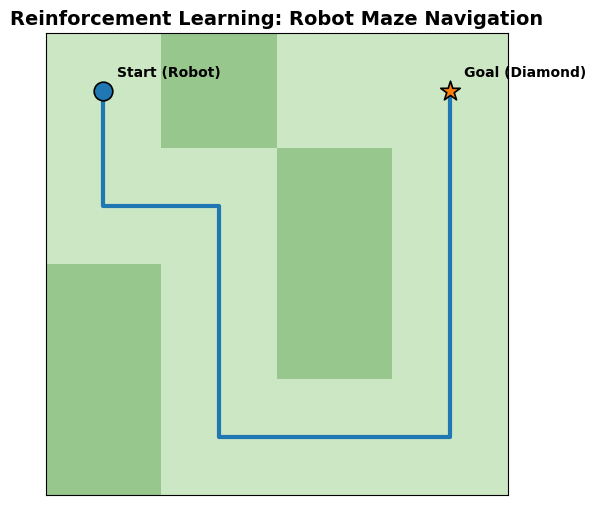

In [56]:
# =========================================
# Step 6: Pretty maze plot (green theme) with path
# =========================================
def plot_maze_with_path(maze, path, start, goal, title="Reinforcement Learning: Robot Maze Navigation"):
    rows, cols = maze.shape

    # Soft green shading for nice look
    bg = np.full_like(maze, 3, dtype=float)   # base = free
    bg[maze == 1] = 1                         # walls darker

    green_cmap = ListedColormap([
        "#b5d9ac", "#98c78e", "#a9d39d",
        "#cbe7c3", "#e0f1da", "#eaf7e6"
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(bg, cmap=green_cmap, vmin=0, vmax=5)

    # Cell grid
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.35)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Start & Goal markers
    ax.scatter(start[1], start[0], marker='o', s=180, edgecolor='black', linewidth=1.2, zorder=4)
    ax.text(start[1]+0.12, start[0]-0.12, "Start (Robot)", fontsize=10, weight="bold")

    ax.scatter(goal[1], goal[0], marker='*', s=220, edgecolor='black', linewidth=1.2, zorder=4)
    ax.text(goal[1]+0.12, goal[0]-0.12, "Goal (Diamond)", fontsize=10, weight="bold")

    # Learned path
    xs = [c for (_, c) in path]
    ys = [r for (r, _) in path]
    ax.plot(xs, ys, linewidth=3, zorder=3)

    ax.set_title(title, fontsize=14, weight="bold")
    plt.show()

plot_maze_with_path(maze, path, start, goal)


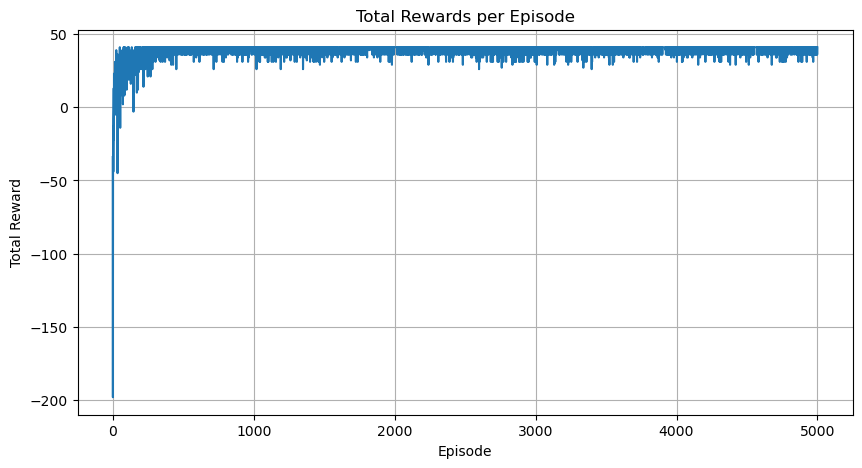

In [58]:
# =========================================
# Step 7: Rewards curve
# =========================================
def plot_rewards(rewards):
    plt.figure(figsize=(10,5))
    plt.plot(rewards)
    plt.title("Total Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.show()

plot_rewards(episode_returns)


In [ ]:
# =========================
# Step 0: Imports & Seed
# =========================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

np.random.seed(42)  # reproducible results



# =========================================
# Step 1: 4x4 Maze, Start, and Goal
# 0 = free cell, 1 = wall
# =========================================
maze = np.array([
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [1, 0, 1, 0],
    [1, 0, 0, 0]
], dtype=int)

start = (0, 0)   # Top-left corner
goal  = (0, 3)   # Bottom-right corner

rows, cols = maze.shape


# =========================================
# Step 2: Hyperparameters
# =========================================
num_episodes = 5000

alpha = 0.1      # learning rate
gamma = 0.9      # discount factor

epsilon = 0.5    # initial exploration
min_epsilon = 0.05
epsilon_decay = 0.995

reward_goal = 50
reward_step = -1

# Actions: left, right, up, down (dr, dc)
actions = [(0,-1), (0,1), (-1,0), (1,0)]
n_actions = len(actions)

# Q-table: one value per (row, col, action)
Q = np.zeros((rows, cols, n_actions))



# =========================================
# Step 3: Environment helpers
# =========================================
def in_bounds(r, c):
    return 0 <= r < rows and 0 <= c < cols

def is_wall(r, c):
    return maze[r, c] == 1

def step(state, action_idx):
    """Take a step. Return next_state, reward, done."""
    r, c = state
    dr, dc = actions[action_idx]
    nr, nc = r + dr, c + dc

    # invalid move (out of bounds or into wall) -> stay & harsher penalty
    if not in_bounds(nr, nc) or is_wall(nr, nc):
        return (r, c), (reward_step - 4), False

    # valid move
    reward = reward_step
    done = False
    if (nr, nc) == goal:
        reward += reward_goal
        done = True
    return (nr, nc), reward, done

def choose_action(state, eps):
    """ε-greedy action choice."""
    r, c = state
    if np.random.rand() < eps:
        return np.random.randint(n_actions)   # explore
    return np.argmax(Q[r, c])                 # exploit



# =========================================
# Step 4: Q-Learning Training
# =========================================
episode_returns = []

for ep in range(num_episodes):
    s = start
    total = 0
    done = False

    for _ in range(400):  # safety cap
        a = choose_action(s, epsilon)
        s2, r, done = step(s, a)

        r0, c0 = s
        r1, c1 = s2
        td_target = r + (0 if done else gamma * np.max(Q[r1, c1]))
        Q[r0, c0, a] += alpha * (td_target - Q[r0, c0, a])

        s = s2
        total += r
        if done:
            break

    episode_returns.append(total)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if (ep+1) % 500 == 0:
        print(f"Episode {ep+1:4d} | avg return (last 500): {np.mean(episode_returns[-500:]):6.2f} | epsilon={epsilon:.3f}")


# =========================================
# Step 5: Get the learned greedy path
# =========================================
def run_greedy(max_steps=400):
    s = start
    path = [s]
    total = 0
    done = False
    for _ in range(max_steps):
        r, c = s
        a = np.argmax(Q[r, c])
        s2, rwd, done = step(s, a)
        path.append(s2)
        total += rwd
        s = s2
        if done:
            break
    return path, total, done

path, total_return, reached = run_greedy()
print("Reached goal:", reached, "| Return:", total_return, "| Steps:", len(path)-1)



# =========================================
# Step 6: Pretty maze plot (green theme) with path
# =========================================
def plot_maze_with_path(maze, path, start, goal, title="Reinforcement Learning: Robot Maze Navigation"):
    rows, cols = maze.shape

    # Soft green shading for nice look
    bg = np.full_like(maze, 3, dtype=float)   # base = free
    bg[maze == 1] = 1                         # walls darker

    green_cmap = ListedColormap([
        "#b5d9ac", "#98c78e", "#a9d39d",
        "#cbe7c3", "#e0f1da", "#eaf7e6"
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(bg, cmap=green_cmap, vmin=0, vmax=5)

    # Cell grid
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5, alpha=0.35)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Start & Goal markers
    ax.scatter(start[1], start[0], marker='o', s=180, edgecolor='black', linewidth=1.2, zorder=4)
    ax.text(start[1]+0.12, start[0]-0.12, "Start (Robot)", fontsize=10, weight="bold")

    ax.scatter(goal[1], goal[0], marker='*', s=220, edgecolor='black', linewidth=1.2, zorder=4)
    ax.text(goal[1]+0.12, goal[0]-0.12, "Goal (Diamond)", fontsize=10, weight="bold")

    # Learned path
    xs = [c for (_, c) in path]
    ys = [r for (r, _) in path]
    ax.plot(xs, ys, linewidth=3, zorder=3)

    ax.set_title(title, fontsize=14, weight="bold")
    plt.show()

plot_maze_with_path(maze, path, start, goal)



# =========================================
# Step 7: Rewards curve
# =========================================
def plot_rewards(rewards):
    plt.figure(figsize=(10,5))
    plt.plot(rewards)
    plt.title("Total Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.show()

plot_rewards(episode_returns)
